In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/mnt/lareaulab/reliscu/code")

from parse_gtf import *

In [2]:
psi_data = "SyntheticDataset1_25pcntCells_100SD_200samples_SJ_pseudobulk_min_observed0.05_PSI"

In [3]:
psi = pd.read_csv(f"data/tasic_2018_ALM_STAR_{psi_data}.csv", index_col=0)
top_qval_mods_df = pd.read_csv("data/tasic_2018_ALM_STAR_donor_cell_type_pseudobulk_pairwise_DE_genes_dream_25pcntCells_100SD_200samples_log2_pseudobulk_PosBC_top_Qval_modules.csv")

In [4]:
gene_expr = pd.read_csv("data/SyntheticDatasets/SyntheticDataset1_25pcntCells_100SD_200samples_11-18-00.csv", index_col=0)

### Add gene names to PSI data

In [5]:
# Parse GTF attribute column
gtf_file = "/mnt/lareaulab/reliscu/data/GENCODE/GRCm39/gencode.vM35.annotation.gtf"
gtf = gtf_parse(gtf_file)
gtf_subset = gtf.loc[gtf['feature'].isin(["gene"])]
attrs = gtf_subset["attribute"].apply(extract_attributes)
attrs_df = attrs.apply(pd.Series)
gtf_parsed = pd.concat([gtf_subset.drop(columns=["attribute"]), attrs_df], axis=1)

In [6]:
# Get PSI and GTF data ready to merge on gene IDs
gtf_parsed['gene_id'] = gtf_parsed['gene_id'].str.split(".").str[0]
psi['gene_id'] = psi.index.str.split("_").str[0]
psi['exon_id'] = psi.index.values

In [7]:
psi_anno = pd.merge(gtf_parsed[['gene_id', 'gene_name']], psi, on="gene_id", how="right")
psi_anno = psi_anno.set_index("exon_id").rename_axis(None)
psi_anno = psi_anno.drop(columns=["gene_id"])

### Calc. corr between ME and exon PSI

In [8]:
corr_df = pd.DataFrame(
    columns=["Gene"] + top_qval_mods_df['Cell_type'].tolist(), 
    index=psi_anno.index
)
corr_df['Gene'] = psi_anno['gene_name'] 

for i, row in top_qval_mods_df.iterrows():
    ctype = row['Cell_type']

    mod_df = pd.read_csv(row['ME_path'])
    mod_eig = mod_df.set_index("Sample")[row['Module']]
    mod_eig = pd.to_numeric(mod_eig, errors="coerce")
    
    corrs = psi_anno.iloc[:, 1:].corrwith(mod_eig, axis=1)
    corr_df[ctype] = corrs

In [9]:
corr_df.head()

,Gene,Astro,Endo,Macrophage,Oligo,SMC,VLMC,L5_IT,Pvalb,Lamp5,L2_3_IT,Sst,Vip,NP,L6_IT,Sncg,L5_PT,L6_CT,Serpinf1,L6b
ENSMUSG00000025902_ProteinCoding_1,Sox17,-0.114326,0.049379,0.022360,0.013979,0.090492,-0.004305,-0.132091,0.152995,-0.047372,-0.080808,-0.017876,-0.018098,-0.050932,0.006227,0.036393,-0.040675,0.020245,0.130366,-0.006883
ENSMUSG00000025902_ProteinCoding_2,Sox17,-0.115290,0.049829,0.022127,0.015273,0.090004,-0.005338,-0.133277,0.152357,-0.047256,-0.080553,-0.017309,-0.017402,-0.050683,0.005794,0.035532,-0.039364,0.020977,0.130200,-0.006032
ENSMUSG00000025902_ProteinCoding_3,Sox17,-0.032828,0.479492,-0.053066,0.014345,0.066446,-0.035713,-0.000755,-0.019018,0.071431,-0.024103,-0.092211,-0.011788,-0.115992,-0.076207,-0.052042,-0.004976,0.019643,-0.093341,-0.005983
ENSMUSG00000025902_ProteinCoding_4,Sox17,-0.025486,0.479089,-0.061437,0.005103,0.081521,-0.040819,-0.005633,-0.003598,0.073075,-0.036491,-0.088909,-0.031221,-0.112138,-0.081132,-0.068777,0.014958,0.029161,-0.108554,-0.011732
ENSMUSG00000033845_ProteinCoding_1,Mrpl15,0.195661,-0.282692,0.030932,-0.273637,0.037326,-0.256692,0.173686,-0.182738,0.123795,0.085133,0.002736,-0.036843,0.112317,0.097253,0.119065,0.101205,-0.084165,0.085491,-0.005052


In [10]:
corr_df.to_csv(f"data/tasic_2018_ALM_STAR_{psi_data}_exon_corr.csv")

In [ ]:
row = top_qval_mods_df.iloc[5]
row

Network      Bicor-None_signum0.893_minSize3_merge_ME_0.96_...
kME_path     /mnt/lareaulab/reliscu/projects/NSF_GRFP/analy...
ME_path      /mnt/lareaulab/reliscu/projects/NSF_GRFP/analy...
Pval                                                       0.0
Cell_type                                                Pvalb
Module                                                   brown
Qval                                                       0.0
Name: 5, dtype: object

In [ ]:
ctype = row['Cell_type']

mod_df = pd.read_csv(row['ME_path'])
mod_eig = mod_df.set_index("Sample")[row['Module']]
mod_eig = pd.to_numeric(mod_eig, errors="coerce")

In [ ]:
import numpy as np

df = gene_expr

# 1) divide each column by its column sum
col_sums = df.sum(axis=0)                     # one value per sample (column)
df_norm = df.div(col_sums, axis=1)            # divide each column by its sum

# 2) log2 transform (add a small pseudocount to avoid log2(0))
df_log2 = np.log2(df_norm + 1)

# 3) multiply by 1e4
df_final = df_log2 * 1e4


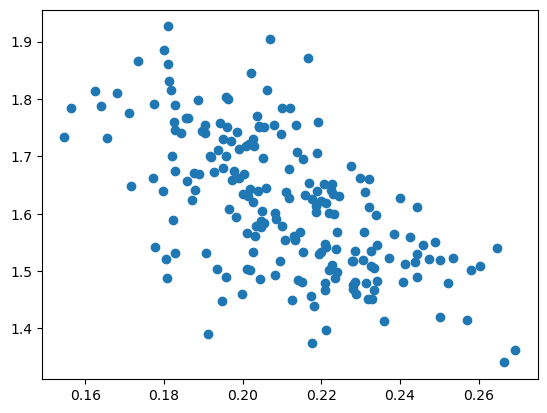

In [82]:
psi_kcnc2 = psi_anno.loc[psi_anno['gene_name'] == "Kcnc2"].iloc[:, 1:]
gene_kcnc2 = df_final.loc["Kcnc2"]
plt.scatter(psi_kcnc2.T['ENSMUSG00000035681_ProteinCoding_1'], gene_kcnc2)

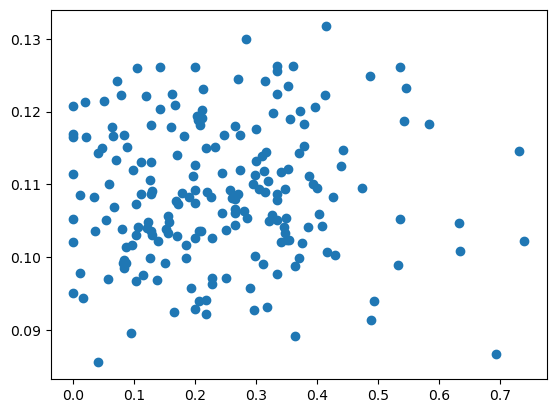

In [78]:
psi_kcnc2 = psi_anno.loc[psi_anno['gene_name'] == "Ank1"].iloc[:, 1:]
gene_kcnc2 = df_final.loc["Ank1"]
plt.scatter(psi_kcnc2.T.iloc[:,0], gene_kcnc2)

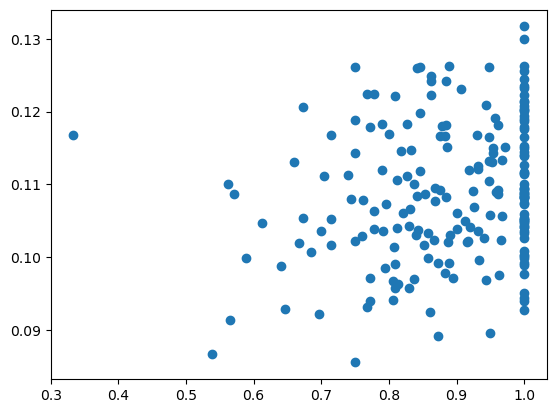

In [81]:
psi_kcnc2 = psi_anno.loc[psi_anno['gene_name'] == "Ank1"].iloc[:, 1:]
gene_kcnc2 = df_final.loc["Ank1"]
plt.scatter(psi_kcnc2.T.iloc[:,2], gene_kcnc2)

In [ ]:
psi_kcnc2 = psi_anno.loc[psi_anno['gene_name'] == "Ank1"].iloc[:, 1:]
gene_kcnc2 = df_final.loc["Ank1"]
plt.scatter(psi_kcnc2.T.iloc[:,2], gene_kcnc2)

,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,Sample9,Sample10,...,Sample191,Sample192,Sample193,Sample194,Sample195,Sample196,Sample197,Sample198,Sample199,Sample200
ENSMUSG00000031543_NMD_1,0.120000,0.263158,0.064935,0.127273,0.016393,0.295082,0.066667,0.492958,0.2,0.441860,...,0.321429,0.313131,0.250000,0.185185,0.142857,0.034483,0.128205,0.272727,0.129412,0.300000
ENSMUSG00000031543_ProteinCoding_2,0.741935,0.823529,0.875000,0.828571,1.000000,1.000000,0.897436,0.692308,1.0,0.809524,...,0.904762,0.813953,0.857143,0.785714,1.000000,1.000000,0.944444,0.714286,0.860465,0.942857
ENSMUSG00000031543_ProteinCoding_3,0.809524,0.842105,0.875000,0.853659,1.000000,1.000000,0.925926,0.771429,1.0,0.833333,...,0.913043,0.846154,0.894737,0.857143,1.000000,1.000000,0.952381,0.789474,0.890909,0.948718


In [25]:
corrs = df_final.corrwith(mod_eig, axis=1)

/mnt/lareaulab/reliscu/anaconda3/envs/anndata/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/lareaulab/reliscu/anaconda3/envs/anndata/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [28]:
corrs.sort_values(ascending=False)

Gene
Atp5mc3    0.974912
Uqcrh      0.966138
Cox7b      0.965989
Atp5pf     0.965440
Cox5b      0.962301
             ...   
Cdk14     -0.715168
Wasf1     -0.743191
Gm17835         NaN
Dyrk4           NaN
Tpsab1          NaN
Length: 40301, dtype: float64